In [1]:
import gym
import tensorflow as tf 
import numpy as np 
import random
from collections import deque

from sklearn.tree import DecisionTreeRegressor

In [2]:
import gym
import tensorflow as tf
import numpy as np
import random
from collections import deque

# Hyper Parameters for DQN
GAMMA = 0.9 # discount factor for target Q
INITIAL_EPSILON = 0.5 # starting value of epsilon
FINAL_EPSILON = 0.01 # final value of epsilon
REPLAY_SIZE = 10000 # experience replay buffer size
BATCH_SIZE = 32 # size of minibatch

class DQN():
  # DQN Agent
  def __init__(self, env):
    # init experience replay
    self.replay_buffer = deque()
    # init some parameters
    self.time_step = 0
    self.epsilon = INITIAL_EPSILON
    self.state_dim = env.observation_space.shape[0]
    self.action_dim = env.action_space.n

    self.create_Q_network()
    self.create_training_method()

    # Init session
    self.session = tf.InteractiveSession()
    self.session.run(tf.initialize_all_variables())

  def create_Q_network(self):
    # network weights
    W1 = self.weight_variable([self.state_dim,20])
    b1 = self.bias_variable([20])
    W2 = self.weight_variable([20,self.action_dim])
    b2 = self.bias_variable([self.action_dim])
    # input layer
    self.state_input = tf.placeholder("float",[None,self.state_dim])
    # hidden layers
    h_layer = tf.nn.relu(tf.matmul(self.state_input,W1) + b1)
    # Q Value layer
    self.Q_value = tf.matmul(h_layer,W2) + b2

  def create_training_method(self):
    self.action_input = tf.placeholder("float",[None,self.action_dim]) # one hot presentation
    self.y_input = tf.placeholder("float",[None])
    Q_action = tf.reduce_sum(tf.multiply(self.Q_value,self.action_input),reduction_indices = 1)
    self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))
    self.optimizer = tf.train.AdamOptimizer(0.0001).minimize(self.cost)

  def perceive(self,state,action,reward,next_state,done):
    one_hot_action = np.zeros(self.action_dim)
    one_hot_action[action] = 1
    self.replay_buffer.append((state,one_hot_action,reward,next_state,done))
    if len(self.replay_buffer) > REPLAY_SIZE:
      self.replay_buffer.popleft()

    if len(self.replay_buffer) > BATCH_SIZE:
      self.train_Q_network()

  def train_Q_network(self):
    self.time_step += 1
    # Step 1: obtain random minibatch from replay memory
    minibatch = random.sample(self.replay_buffer,BATCH_SIZE)
    state_batch = [data[0] for data in minibatch]
    action_batch = [data[1] for data in minibatch]
    reward_batch = [data[2] for data in minibatch]
    next_state_batch = [data[3] for data in minibatch]

    # Step 2: calculate y
    y_batch = []
    Q_value_batch = self.Q_value.eval(feed_dict={self.state_input:next_state_batch})
    for i in range(0,BATCH_SIZE):
      done = minibatch[i][4]
      if done:
        y_batch.append(reward_batch[i])
      else :
        y_batch.append(reward_batch[i] + GAMMA * np.max(Q_value_batch[i]))

    self.optimizer.run(feed_dict={
      self.y_input:y_batch,
      self.action_input:action_batch,
      self.state_input:state_batch
      })

  def egreedy_action(self,state):
    Q_value = self.Q_value.eval(feed_dict = {
      self.state_input:[state]
      })[0]
    if random.random() <= self.epsilon:
      return random.randint(0,self.action_dim - 1)
    else:
      return np.argmax(Q_value)

    self.epsilon -= (INITIAL_EPSILON - FINAL_EPSILON)/10000

  def action(self,state):
    return np.argmax(self.Q_value.eval(feed_dict = {
      self.state_input:[state]
      })[0])

  def weight_variable(self,shape):
    initial = tf.truncated_normal(shape)
    return tf.Variable(initial)

  def bias_variable(self,shape):
    initial = tf.constant(0.01, shape = shape)
    return tf.Variable(initial)
# ---------------------------------------------------------
# Hyper Parameters
ENV_NAME = 'CartPole-v0'
EPISODE = 10000 # Episode limitation
STEP = 300 # Step limitation in an episode
TEST = 10 # The number of experiment test every 100 episode

def main():
  # initialize OpenAI Gym env and dqn agent
  env = gym.make(ENV_NAME)
  agent = DQN(env)

  for episode in xrange(EPISODE):
    # initialize task
    state = env.reset()
    # Train
    for step in xrange(STEP):
      action = agent.egreedy_action(state, e = 0.05) # e-greedy action for train
      next_state,reward,done,_ = env.step(action)
      # Define reward for agent
      reward_agent = -1 if done else 0.1
      agent.perceive(state,action,reward,next_state,done)
      state = next_state
      if done:
        break
    # Test every 100 episodes
    if episode % 100 == 0:
      total_reward = 0
      for i in xrange(TEST):
        state = env.reset()
        for j in xrange(STEP):
          env.render()
          action = agent.action(state) # direct action for test
          state,reward,done,_ = env.step(action)
          total_reward += reward
          if done:
            break
      ave_reward = total_reward/TEST
      print 'episode: ',episode,'Evaluation Average Reward:',ave_reward
      if ave_reward >= 200:
        break

In [4]:
class tree_agent():
    
    def __init__(self, env, discount = 0.9, delta = 0., beta = 1):
        # init some parameters
        self.time_step = 0
        self.past_experience = [] 
        #self.n_warm_up = 100 
        
        self.update_frequency = 50
        self.beta = beta
        
        self.state_dim = env.observation_space.shape[0] 
        self.action_dim = env.action_space.n
        self.model = DecisionTreeRegressor(min_impurity_decrease=delta, splitter = 'random') 
        self.discount = discount
        self.model.fit([[0]*self.state_dim + [0] ], [0])

    def perceive(self,state,action,reward,next_state, done):
        
        pred, _ = self.model.predict(np.array([ list(next_state)+ [0], list(next_state) + [1] ] ))
        
        if done:
            Q_value = reward
        else:
            Q_value = reward + self.discount * np.max(pred) # binary actions
            
        self.past_experience.append( list(state) + [action] + [Q_value] )
        
        #print 'here'
        if len(self.past_experience) % self.update_frequency == 0:
            self.update_tree(episode)
        
    def update_tree(self, episode):
        #if len(self.past_experience) > 40000:
        #    self.model.fit( np.array(self.past_experience)[5000:,:-1] , np.array(self.past_experience)[5000:,-1] )
        #else:
            
        self.model.fit( np.array(self.past_experience)[:,:-1]  , np.array(self.past_experience)[:,-1] 
                         )
        
            
    def action(self, state, v = 1, e = 0):
        r = np.random.uniform(0,1)
        if r<e:
            return np.random.choice([0,1])
        else:
            pred, uncertainty = self.model.predict(np.array([list(state) + [0],
                                   list(state) + [1]]))
                
            #print uncertainty

            UCB = pred + self.beta * uncertainty
            return np.random.choice(np.flatnonzero(UCB == UCB.max()))

In [6]:
# initialize OpenAI Gym env and dqn agent
ENV_NAME = 'CartPole-v0'

env = gym.make(ENV_NAME)
agent = DQN(env)

t_agent = tree_agent(env, delta=0.0001, beta = 0.5)

res_dqn = []

for episode in xrange(2001):
    # initialize task
    state = env.reset()
    # Train
    
    if episode < 500:
        for step in xrange(STEP):
            action = t_agent.action(state) # e-greedy action for train
            next_state,reward,done,_ = env.step(action)
            # Define reward for agent
            if done and step<199:
                reward = -20.
            else:
                reward = 2.
            agent.perceive(state,action,reward,next_state, done)
            t_agent.perceive(state,action,reward,next_state, done)
            state = next_state
            if done:
                break
    else:
        for step in xrange(STEP):
            action = agent.egreedy_action(state) # e-greedy action for train
            next_state,reward,done,_ = env.step(action)
            # Define reward for agent
            if done and step<199:
                reward = -20.
            else:
                reward = 2.
            agent.perceive(state,action,reward,next_state,done)
            state = next_state
            if done:
                break
            # Test every 100 episodes
    if episode % 100 == 0:
        total_reward = 0
        for i in xrange(TEST):
            state = env.reset()
            for j in xrange(STEP):
                env.render()
                action = agent.action(state) # direct action for test
                state,reward,done,_ = env.step(action)
                total_reward += reward
                if done:
                    break
        ave_reward = total_reward/TEST
        res_dqn.append(ave_reward)
        print 'episode: ',episode,'Evaluation Average Reward:',ave_reward
        #if ave_reward >= 200:
        #    break

[2017-12-12 22:03:49,746] Making new env: CartPole-v0


Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-12-12 22:03:49,950] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/util/tf_should_use.py:175: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


KeyboardInterrupt: 

In [16]:
# env = gym.make('CartPole-v0')
agent = tree_agent(env, delta=0.0001, beta = 0.5)

res_tree = []

for episode in xrange(2001):
    # initialize task
    state = env.reset()
    # Train
    for step in xrange(STEP):
        action = agent.action(state) # e-greedy action for train
        next_state,reward,done,_ = env.step(action)
        # Define reward for agent
        if done and step<199:
            reward = -20.
        else:
            reward = 2.
        agent.perceive(state,action,reward,next_state, done)
        state = next_state
        if done:
            break
            # Test every 100 episodes
    if episode % 100 == 0:
        total_reward = 0
        for i in xrange(TEST):
            state = env.reset()
            
            for j in xrange(STEP):
                env.render()
                action = agent.action(state) # direct action for test
                state,reward,done,_ = env.step(action)
                total_reward += reward
                if done:
                    break
        ave_reward = total_reward/TEST
        res_tree.append(ave_reward)
        print 'episode: ',episode,'Evaluation Average Reward:',ave_reward, 'past experience length', len(agent.past_experience)
        #if ave_reward >= 195: 
        #    break

episode:  0 Evaluation Average Reward: 18.5 past experience length 18
episode:  100 Evaluation Average Reward: 28.8 past experience length 3142
episode:  200 Evaluation Average Reward: 68.8 past experience length 7310
episode:  300 Evaluation Average Reward: 96.5 past experience length 13291
episode:  400 Evaluation Average Reward: 81.9 past experience length 21122
episode:  500 Evaluation Average Reward: 100.3 past experience length 30730
episode:  600 Evaluation Average Reward: 136.2 past experience length 41108
episode:  700 Evaluation Average Reward: 137.8 past experience length 53732
episode:  800 Evaluation Average Reward: 120.3 past experience length 67708
episode:  900 Evaluation Average Reward: 167.9 past experience length 81887
episode:  1000 Evaluation Average Reward: 138.9 past experience length 94959
episode:  1100 Evaluation Average Reward: 187.2 past experience length 109737
episode:  1200 Evaluation Average Reward: 161.2 past experience length 124860
episode:  1300 Eval

KeyboardInterrupt: 

In [ ]:

env = gym.make(ENV_NAME)
agent_dqn = DQN(env)
agent_tree = tree_agent(env)
    
res = []

for episode in xrange(EPISODE):
    # initialize task
    state = env.reset()
    # Train
    for step in xrange(STEP):
        action = agent_dqn.egreedy_action(state) # e-greedy action for train
        next_state,reward,done,_ = env.step(action)
        # Define reward for agent
        reward = -100 if done else 10
        agent_tree.perceive(state,action,reward,next_state,done)
        
        if done:
            break
        
        action = agent_tree.action(state) # e-greedy action for train
        next_state,reward,done,_ = env.step(action)
        # Define reward for agent
        reward = -1 if done else 0.1
        agent_dqn.perceive(state,action,reward,next_state,done)
        
        state = next_state
        if done:
            break
            # Test every 100 episodes
    if episode % 100 == 0:
        total_reward = 0
        for i in xrange(TEST):
            state = env.reset()
            for j in xrange(STEP):
                env.render()
                action = agent_dqn.action(state) # direct action for test
                state,reward,done,_ = env.step(action)
                total_reward += reward
                if done:
                    break
        ave_reward = total_reward/TEST
        print 'episode: ',episode,'Evaluation Average Reward:',ave_reward
        res.append(ave_reward)
        if ave_reward >= 200:
            break

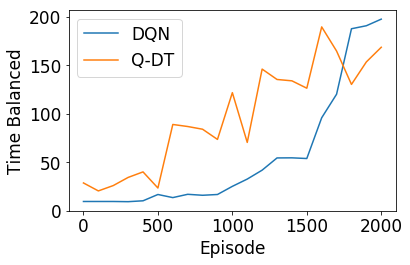

In [32]:
#import matplotlib.pyplot as plt
#%matplotlib inline

#import matplotlib
#matplotlib.rcParams.update({'font.size': 17})

#l1, = plt.plot((np.array(range(21)))*100, res_dqn, label = 'DQN')
#l2, = plt.plot((np.array(range(21)))*100, res_tree, label = 'Q-DT')
#l3, = plt.plot((np.array(range(21)))*100, res_hybrid, label = 'hybrid')
#plt.xlabel('Episode')
#plt.ylabel('Time Balanced')
#plt.plot(res_tree_e)

#plt.legend(handles = [l1, l2])

#plt.tight_layout()
#plt.show()

#plt.savefig('comparison.png', dpi = 150) 